CPA.py file

# CPA

In [250]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar  4 02:08:22 2020

@author: stjepan
@adjusted by: Menno

Assignment: Guessing entropy over number of traces
"""


import numpy as np
import matplotlib.pyplot as plt

HW = [bin(n).count("1") for n in range(0,256)]

sbox=(
0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16)

def intermediate(pt, keyguess):
    return sbox[pt ^ keyguess]



traces = np.load(r'.\chipwhisperer\traces.npy')
pt = np.load(r'.\chipwhisperer\plain.npy')
knownkey = np.load(r'.\chipwhisperer\key.npy')

numtraces = np.shape(traces)[0]-1
numpoint = np.shape(traces)[1]
original_traces = traces
exp_to_run = 100
results = list()
experiments = range(1, 40, 2)

#Use less than the maximum traces by setting numtraces to something
for numtraces in experiments:
    ge_total = 0
    for _ in range(exp_to_run):
        random_start = randint(0, len(original_traces) - numtraces)
        random_end = random_start + numtraces
        if random_end > 10000:
            print(random_end)
#         print(f'random range: {random_start}:{random_end}')

        traces = original_traces[random_start:random_end,:]

        #Set 16 to something lower (like 1) to only go through a single subkey
        bestguess = [0]*16
        ge = np.zeros(16)
        for bnum in range(0, 1):
            cpaoutput = [0]*256
            maxcpa = [0]*256
            for kguess in range(0, 256):
                #print ("Subkey %2d, hyp = %02x: "%(bnum, kguess)),

                #Initialize arrays & variables to zero
                sumnum = np.zeros(numpoint)
                sumden1 = np.zeros(numpoint)
                sumden2 = np.zeros(numpoint)

                hyp = np.zeros(numtraces)
                for tnum in range(0, numtraces):
                    hyp[tnum] = HW[intermediate(pt[random_start + tnum][bnum], kguess)]

                #Mean of hypothesis
                meanh = np.mean(hyp, dtype=np.float64)

                #Mean of all points in trace
                meant = np.mean(traces, axis=0, dtype=np.float64)

                #For each trace, do the following
                for tnum in range(0, numtraces):
                    hdiff = (hyp[tnum] - meanh)
                    tdiff = traces[tnum,:] - meant

                    sumnum = sumnum + (hdiff*tdiff)
                    sumden1 = sumden1 + hdiff*hdiff 
                    sumden2 = sumden2 + tdiff*tdiff

                cpaoutput[kguess] = sumnum / np.sqrt( sumden1 * sumden2 )
                maxcpa[kguess] = max(abs(cpaoutput[kguess]))

            bestguess[bnum] = np.argmax(maxcpa)
            cparefs = np.argsort(maxcpa)[::-1]

            #Find GE
            ge[bnum] = list(cparefs).index(knownkey[0][bnum])

#         print ("Best Key Guess: ",bestguess[b], " GE: ", ge[b])
        ge_total += ge[b]
    print ("Number of traces: ", numtraces, "Average Key Guess: ", ge_total / exp_to_run)
    results.append(ge_total / exp_to_run)
    print(results)


<ipython-input-250-d1a6bc5c3edc>:97: RuntimeWarning: invalid value encountered in true_divide
  cpaoutput[kguess] = sumnum / np.sqrt( sumden1 * sumden2 )


Number of traces:  1 Average Key Guess:  116.0
[116.0]
Number of traces:  3 Average Key Guess:  103.72
[116.0, 103.72]
Number of traces:  5 Average Key Guess:  127.43
[116.0, 103.72, 127.43]
Number of traces:  7 Average Key Guess:  115.09
[116.0, 103.72, 127.43, 115.09]
Number of traces:  9 Average Key Guess:  94.35
[116.0, 103.72, 127.43, 115.09, 94.35]
Number of traces:  11 Average Key Guess:  81.19
[116.0, 103.72, 127.43, 115.09, 94.35, 81.19]
Number of traces:  13 Average Key Guess:  61.86
[116.0, 103.72, 127.43, 115.09, 94.35, 81.19, 61.86]
Number of traces:  15 Average Key Guess:  34.67
[116.0, 103.72, 127.43, 115.09, 94.35, 81.19, 61.86, 34.67]
Number of traces:  17 Average Key Guess:  31.38
[116.0, 103.72, 127.43, 115.09, 94.35, 81.19, 61.86, 34.67, 31.38]
Number of traces:  19 Average Key Guess:  15.17
[116.0, 103.72, 127.43, 115.09, 94.35, 81.19, 61.86, 34.67, 31.38, 15.17]
Number of traces:  21 Average Key Guess:  5.04
[116.0, 103.72, 127.43, 115.09, 94.35, 81.19, 61.86, 34.

<function matplotlib.pyplot.show(close=None, block=None)>

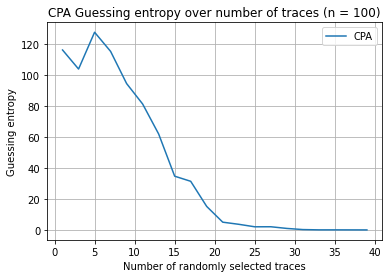

In [251]:
# Use the guessing entropy metric (explains in video from 1:00:00)
import matplotlib.pyplot as plt
plt.plot(experiments, results, label = "CPA")
plt.xlabel('Number of randomly selected traces')
plt.ylabel('Guessing entropy') #, rotation=0
plt.title('CPA Guessing entropy over number of traces (n = 100)')
plt.legend()
plt.grid()
plt.show

In [253]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar  4 02:08:22 2020

@author: stjepan
@adjusted by: Menno

Assignment: Attack the whole key (all 16 subkeys)
"""


import numpy as np
import matplotlib.pyplot as plt

HW = [bin(n).count("1") for n in range(0,256)]

sbox=(
0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16)

def intermediate(pt, keyguess):
    return sbox[pt ^ keyguess]



traces = np.load(r'.\chipwhisperer\traces.npy')
pt = np.load(r'.\chipwhisperer\plain.npy')
knownkey = np.load(r'.\chipwhisperer\key.npy')

numtraces = np.shape(traces)[0]-1
numpoint = np.shape(traces)[1]
original_traces = traces
exp_to_run = 100
result_dict = {k:list() for k in range(16)}

result_dict["average"] = list()
experiments = range(5, 40, 5)


#Use less than the maximum traces by setting numtraces to something
for numtraces in experiments:
    ge_total = [0]*16
    ge_count = 0
    for _ in range(exp_to_run):
        random_start = randint(0, len(original_traces) - numtraces)
        random_end = random_start + numtraces
        if random_end > 10000:
            print(random_end)
#         print(f'random range: {random_start}:{random_end}')

        traces = original_traces[random_start:random_end,:]

        #Set 16 to something lower (like 1) to only go through a single subkey
        bestguess = [0]*16
        ge = np.zeros(16)
        for bnum in range(16):
            cpaoutput = [0]*256
            maxcpa = [0]*256
            for kguess in range(0, 256):
                #print ("Subkey %2d, hyp = %02x: "%(bnum, kguess)),

                #Initialize arrays & variables to zero
                sumnum = np.zeros(numpoint)
                sumden1 = np.zeros(numpoint)
                sumden2 = np.zeros(numpoint)

                hyp = np.zeros(numtraces)
                for tnum in range(0, numtraces):
                    hyp[tnum] = HW[intermediate(pt[random_start + tnum][bnum], kguess)]


                #Mean of hypothesis
                meanh = np.mean(hyp, dtype=np.float64)

                #Mean of all points in trace
                meant = np.mean(traces, axis=0, dtype=np.float64)

                #For each trace, do the following
                for tnum in range(0, numtraces):
                    hdiff = (hyp[tnum] - meanh)
                    tdiff = traces[tnum,:] - meant

                    sumnum = sumnum + (hdiff*tdiff)
                    sumden1 = sumden1 + hdiff*hdiff 
                    sumden2 = sumden2 + tdiff*tdiff

                cpaoutput[kguess] = sumnum / np.sqrt( sumden1 * sumden2 )
                maxcpa[kguess] = max(abs(cpaoutput[kguess]))

            bestguess[bnum] = np.argmax(maxcpa)

            cparefs = np.argsort(maxcpa)[::-1]

            #Find GE
            ge[bnum] = list(cparefs).index(knownkey[0][bnum])
        
        for b in range (0, 16): 
#             print ("Key: ", b, "Best Key Guess: ", bestguess[b], " GE: ", ge[b])
            ge_total[b] += ge[b]
    all_keys_average = 0
    for b in range (0, 16): 
        key_average = int(ge_total[b] / exp_to_run)
#         print("Key: ", b, " GE-average: ", key_average)
        result_dict[b].append(key_average)
        all_keys_average += key_average
        print(result_dict[b])
    result_dict["average"].append(all_keys_average / 16)

<ipython-input-253-12e70b11c673>:101: RuntimeWarning: invalid value encountered in true_divide
  cpaoutput[kguess] = sumnum / np.sqrt( sumden1 * sumden2 )


[120]
[113]
[134]
[119]
[136]
[142]
[128]
[125]
[127]
[134]
[128]
[119]
[127]
[135]
[112]
[112]
[120, 92]
[113, 57]
[134, 64]
[119, 80]
[136, 107]
[142, 65]
[128, 73]
[125, 76]
[127, 100]
[134, 72]
[128, 67]
[119, 61]
[127, 96]
[135, 70]
[112, 73]
[112, 32]
[120, 92, 37]
[113, 57, 13]
[134, 64, 22]
[119, 80, 18]
[136, 107, 81]
[142, 65, 12]
[128, 73, 24]
[125, 76, 20]
[127, 100, 72]
[134, 72, 22]
[128, 67, 19]
[119, 61, 14]
[127, 96, 58]
[135, 70, 25]
[112, 73, 19]
[112, 32, 3]
[120, 92, 37, 5]
[113, 57, 13, 1]
[134, 64, 22, 3]
[119, 80, 18, 4]
[136, 107, 81, 31]
[142, 65, 12, 1]
[128, 73, 24, 4]
[125, 76, 20, 4]
[127, 100, 72, 39]
[134, 72, 22, 3]
[128, 67, 19, 2]
[119, 61, 14, 3]
[127, 96, 58, 19]
[135, 70, 25, 5]
[112, 73, 19, 3]
[112, 32, 3, 0]
[120, 92, 37, 5, 2]
[113, 57, 13, 1, 0]
[134, 64, 22, 3, 1]
[119, 80, 18, 4, 0]
[136, 107, 81, 31, 9]
[142, 65, 12, 1, 0]
[128, 73, 24, 4, 0]
[125, 76, 20, 4, 0]
[127, 100, 72, 39, 18]
[134, 72, 22, 3, 0]
[128, 67, 19, 2, 0]
[119, 61, 14, 3,

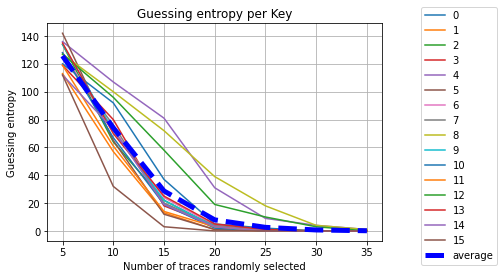

In [264]:
import matplotlib.pyplot as plt
for key in result_dict:
    if key == "average":
        plt.plot(experiments, result_dict[key], 'b--', label = key, linewidth=5)
        continue
    plt.plot(experiments, result_dict[key], label = key)
    
plt.xlabel('Number of traces randomly selected')
plt.ylabel('Guessing entropy') #, rotation=0
plt.title('Guessing entropy per Key')
plt.legend(bbox_to_anchor=(1.1, 1.1))
plt.grid()
plt.show()

In [247]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar  4 02:08:22 2020

@author: stjepan
@adjusted by: Menno

Assignment: Implement Online CPA
"""


import numpy as np
import matplotlib.pyplot as plt

HW = [bin(n).count("1") for n in range(0,256)]

sbox=(
0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16)

def intermediate(pt, keyguess):
    return sbox[pt ^ keyguess]



traces = np.load(r'.\chipwhisperer\traces.npy')
pt = np.load(r'.\chipwhisperer\plain.npy')
knownkey = np.load(r'.\chipwhisperer\key.npy')

numtraces = np.shape(traces)[0]-1
numpoint = np.shape(traces)[1]
original_traces = traces
exp_to_run = 100
results = list()
experiments = range(5, 40, 5)


#Use less than the maximum traces by setting numtraces to something
for numtraces in experiments:
    ge_total = 0
    ge_count = 0
    for _ in range(exp_to_run):
        random_start = randint(0, len(original_traces) - numtraces)
        random_end = random_start + numtraces
        if random_end > 10000:
            print(random_end)
#         print(f'random range: {random_start}:{random_end}')

        traces = original_traces[random_start:random_end,:]

        #Set 16 to something lower (like 1) to only go through a single subkey
        bestguess = [0]*16
        ge = np.zeros(16)
        for bnum in range(1):
            cpaoutput = [0]*256
            maxcpa = [0]*256
            for kguess in range(0, 256):
                #print ("Subkey %2d, hyp = %02x: "%(bnum, kguess)),

                #Initialize arrays & variables to zero
                sum_h_t = np.zeros(numpoint)
                sum_h = np.zeros(numpoint)
                sum_t = np.zeros(numpoint)
                square_h = np.zeros(numpoint)
                square_t = np.zeros(numpoint)

                hyp = np.zeros(numtraces)
                for tnum in range(0, numtraces):
                    hyp[tnum] = HW[intermediate(pt[random_start + tnum][bnum], kguess)]


                #Mean of hypothesis
                meanh = np.mean(hyp, dtype=np.float64)

                #Mean of all points in trace
                meant = np.mean(traces, axis=0, dtype=np.float64)

                #For each trace, do the following
                for tnum in range(numtraces):
                    h_d = hyp[tnum]
                    t_d = traces[tnum,:] 

                    sum_h_t = sum_h_t + h_d * t_d
                    sum_h = sum_h + h_d
                    sum_t = sum_t + t_d
                    square_h = square_h + (h_d * h_d)
                    square_t = square_t + (t_d * t_d)
                
                tnum = tnum + 1
#                 print(f'tnum: {tnum}')
                numerator = tnum * sum_h_t - (sum_h * sum_t)
                denum_1 = (sum_h * sum_h) - tnum * square_h
                denum_2 = (sum_t * sum_t) - tnum * square_t

                cpaoutput[kguess] = numerator / np.sqrt(denum_1 * denum_2)
                maxcpa[kguess] = max(abs(cpaoutput[kguess]))

            bestguess[bnum] = np.argmax(maxcpa)

            cparefs = np.argsort(maxcpa)[::-1]

            #Find GE
            ge[bnum] = list(cparefs).index(knownkey[0][bnum])
        
#         print ("Best Key Guess: ",bestguess[b], " GE: ", ge[b])
        ge_total += ge[b]
    print ("Number of traces: ", numtraces, "Average Key Guess: ", ge_total / exp_to_run)

    results.append(ge_total / exp_to_run)
    print(results)


<ipython-input-247-ee40deb223dc>:109: RuntimeWarning: invalid value encountered in true_divide
  cpaoutput[kguess] = numerator / np.sqrt(denum_1 * denum_2)


Number of traces:  5 Average Key Guess:  122.24
[122.24]
Number of traces:  10 Average Key Guess:  87.31
[122.24, 87.31]
Number of traces:  15 Average Key Guess:  40.2
[122.24, 87.31, 40.2]
Number of traces:  20 Average Key Guess:  11.7
[122.24, 87.31, 40.2, 11.7]
Number of traces:  25 Average Key Guess:  2.27
[122.24, 87.31, 40.2, 11.7, 2.27]
Number of traces:  30 Average Key Guess:  0.99
[122.24, 87.31, 40.2, 11.7, 2.27, 0.99]
Number of traces:  35 Average Key Guess:  0.02
[122.24, 87.31, 40.2, 11.7, 2.27, 0.99, 0.02]


<function matplotlib.pyplot.show(close=None, block=None)>

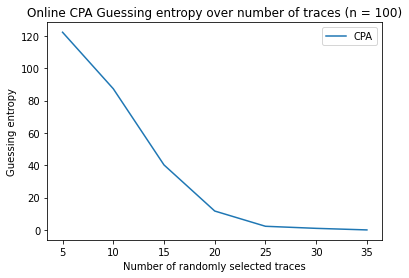

In [249]:
# Use the guessing entropy metric (explains in video from 1:00:00)
import matplotlib.pyplot as plt
plt.plot(experiments, results, label = "CPA")
plt.xlabel('Number of randomly selected traces')
plt.ylabel('Guessing entropy') #, rotation=0
plt.title('Online CPA Guessing entropy over number of traces (n = 100)')
plt.legend()
plt.show

# Constant time algorithms

In [358]:
def square_multiply(base, exp, mod):
    # Always starts with 0b prefix so we start at 2
    d = bin(exp)[3:]
    value = base
    
    for bit in d:
        value = (value * value) % mod
        if bit == '1':value = (value * base) % mod
    return value

def square_multiply_always(base, exp, mod):
    R0 = 1
    R1 = base
    c = bin(exp)[2:][::-1]
    i = len(c)-1
    t = 0
    
    while i >= 0:
        if t == 0: Rt = R0
        elif t == 1: Rt = R1
        R0 = (R0 * Rt) % mod
        d = int(c[i])
        t = (t ^ d)
        i = i - 1 + t
    return R0

def montgomery_ladder(base, exp, mod):
    R0 = 1
    R1 = base
    c = bin(exp)[2:][::-1]
    i = len(c)-1
    
    while i >= 0:
        if int(c[i]) == 1:
            R0 = (R0 * R1) % mod
            R1 = (R1 * R1) % mod
        else:
            R1 = (R0 * R1) % mod
            R0 = (R0 * R0) % mod
        i -= 1
    return R0

large_number = 10498120481283974297589327093284981279438729874321012873509823758720347018297349018237492817597823057982735897532
larger_number = large_number * large_number * large_number * large_number * large_number * large_number * large_number * large_number * large_number * large_number
for _ in range(10):
    larger_number = larger_number * larger_number

print('big number ready')

start = time.time()
exp_to_run = 30
for _ in range(exp_to_run):
    (square_multiply(3, larger_number, large_number))
print(f'square multiply, average time taken: {(time.time() - start) / exp_to_run}')

start = time.time()   
for _ in range(exp_to_run):
    (square_multiply_always(3, larger_number, large_number))
print(f'square multiply always, average time taken: {(time.time() - start) / exp_to_run}')

start = time.time() 
for _ in range(exp_to_run):
    (montgomery_ladder(3, larger_number, large_number))
print(f'montgomery ladder, average time taken: {(time.time() - start) / exp_to_run}')

# 9.3 sec avg without turbo

big number ready
square multiply, average time taken: 3.055241107940674
square multiply always, average time taken: 4.891847157478333
montgomery ladder, average time taken: 6.37878778775533
